# Dissecting Spotify Valence

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find [here](https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013)

In this assignment I will dissect Spotify's Valence metric. I will untangle the mystery behind valence and propose how this is derived.

> Maria Aspasia Stefadourou <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business, <br />
> mariaspastef@gmail.com <br />
> Course Applied Machine Learning taught by: Panos Louridas, Associate Professor <br />

## A1: Expore which Features Influence Valence

### Introduction

Here are some important info about the features we will see in the notebook that are analyzed at [Spotify API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

> Valence describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). It has values ranging from 0.0 to 1.0.

The features we are going to use to find the best models to predict valence are the following.
* *acousticness*, which is a measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* *danceability*, which describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. 1.0 represents the most danceable.
* *duration_ms*, which represents the duration of the track in milliseconds.
* *energy*, which represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 1.0 represents the most energeyic tracks.
* *instrumentalness*, which predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 
* *key*, which represents the key the track is in. Integers map to pitches using standard Pitch Class notation.
* *liveness*, which detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
* *loudness*, The overall loudness of a track in decibels (dB). Values typically range between -60 and 0 db.
* *mode*, which indicates the modality (major or minor) of a track. Major is represented by 1 and minor is 0.
* *speechiness*, which detects the presence of spoken words in a track. The more exclusively speech-like the recording, the closer to 1.0 the attribute value.
* *tempo*, which represents the overall estimated tempo of a track in beats per minute (BPM).
* *time_signature*, which specifies how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

### Preparation

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

I searched in kaggle for a Spotify dataset. I chose *Spotify and Genius Track*, that can be found in this [link](https://www.kaggle.com/saurabhshahane/spotgen-music-dataset). It is updated reguraly and very usable.

DON'T FORGET <br> </br>
*Before running the notebook you should have the following file *spotify_tracks.csv* in the same folder with this notebook*

This csv file has circa 100000 unique song ids and among others columns the ones that will be used for the valence analysis.


In [2]:
tracks = pd.read_csv('spotify_tracks.csv')
tracks.head()

,Unnamed: 0,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
0,0,0.294,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,...,https://p.scdn.co/mp3-preview/1b05a902da3a251d...,0.0262,115.018,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.6220,track
1,1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,...,https://p.scdn.co/mp3-preview/d8140736a6131cb5...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.5890,track
2,2,0.750,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1L3Y...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.466,1.0,492840.0,...,https://p.scdn.co/mp3-preview/c8af28fb15185b18...,0.9440,79.565,4.0,https://api.spotify.com/v1/tracks/1L3YAhsEMrGV...,track_4,4.0,spotify:track:1L3YAhsEMrGVvCgDXj2TYn,0.0850,track
3,3,0.763,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,...,https://p.scdn.co/mp3-preview/7629b8e9f31f6e9b...,0.9380,112.822,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.5330,track
4,4,0.770,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1Vo8...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.460,1.0,558880.0,...,https://p.scdn.co/mp3-preview/32be593c0eb82868...,0.9430,81.260,4.0,https://api.spotify.com/v1/tracks/1Vo802A38tPF...,track_2,2.0,spotify:track:1Vo802A38tPFHmje1h91um,0.0906,track


In [3]:
all_tracks = tracks.copy()

We change the name of the column that contains the song ids.

In [4]:
all_tracks = all_tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
all_tracks.head()

,Unnamed: 0,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
0,0,0.294,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,...,https://p.scdn.co/mp3-preview/1b05a902da3a251d...,0.0262,115.018,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.6220,track
1,1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,...,https://p.scdn.co/mp3-preview/d8140736a6131cb5...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.5890,track
2,2,0.750,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1L3Y...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.466,1.0,492840.0,...,https://p.scdn.co/mp3-preview/c8af28fb15185b18...,0.9440,79.565,4.0,https://api.spotify.com/v1/tracks/1L3YAhsEMrGV...,track_4,4.0,spotify:track:1L3YAhsEMrGVvCgDXj2TYn,0.0850,track
3,3,0.763,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,...,https://p.scdn.co/mp3-preview/7629b8e9f31f6e9b...,0.9380,112.822,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.5330,track
4,4,0.770,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1Vo8...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.460,1.0,558880.0,...,https://p.scdn.co/mp3-preview/32be593c0eb82868...,0.9430,81.260,4.0,https://api.spotify.com/v1/tracks/1Vo802A38tPF...,track_2,2.0,spotify:track:1Vo802A38tPFHmje1h91um,0.0906,track


We drop this unneeded column

In [5]:
all_tracks.drop(['Unnamed: 0'], axis=1, inplace=True)
all_tracks.head()

,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,energy,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
0,0.294,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,0.606,...,https://p.scdn.co/mp3-preview/1b05a902da3a251d...,0.0262,115.018,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.6220,track
1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,0.308,...,https://p.scdn.co/mp3-preview/d8140736a6131cb5...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.5890,track
2,0.750,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1L3Y...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.466,1.0,492840.0,0.931,...,https://p.scdn.co/mp3-preview/c8af28fb15185b18...,0.9440,79.565,4.0,https://api.spotify.com/v1/tracks/1L3YAhsEMrGV...,track_4,4.0,spotify:track:1L3YAhsEMrGVvCgDXj2TYn,0.0850,track
3,0.763,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,0.126,...,https://p.scdn.co/mp3-preview/7629b8e9f31f6e9b...,0.9380,112.822,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.5330,track
4,0.770,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1Vo8...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.460,1.0,558880.0,0.942,...,https://p.scdn.co/mp3-preview/32be593c0eb82868...,0.9430,81.260,4.0,https://api.spotify.com/v1/tracks/1Vo802A38tPF...,track_2,2.0,spotify:track:1Vo802A38tPFHmje1h91um,0.0906,track


### Exploration

Now lets explore a bit more with our dataset.
* First we see the number of columns.

In [6]:
all_tracks.columns

Index(['acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'song_id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')

* Then the number of unique song ids.

In [7]:
len(all_tracks['song_id'].unique())

101939

* We check for duplicate records and see there are none.

In [8]:
all_tracks.duplicated().sum()

0

* We check for Null values and see there are none.

In [9]:
all_tracks.isnull().sum().sum()

0

* Info about the dataset

In [10]:
all_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101939 entries, 0 to 101938
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   acousticness       101939 non-null  float64
 1   album_id           101939 non-null  object 
 2   analysis_url       101939 non-null  object 
 3   artists_id         101939 non-null  object 
 4   available_markets  101939 non-null  object 
 5   country            101939 non-null  object 
 6   danceability       101939 non-null  float64
 7   disc_number        101939 non-null  float64
 8   duration_ms        101939 non-null  float64
 9   energy             101939 non-null  float64
 10  href               101939 non-null  object 
 11  song_id            101939 non-null  object 
 12  instrumentalness   101939 non-null  float64
 13  key                101939 non-null  float64
 14  liveness           101939 non-null  float64
 15  loudness           101939 non-null  float64
 16  ly

* We see which columns are numeric

In [11]:
all_tracks.columns[all_tracks.dtypes != 'object']

Index(['acousticness', 'danceability', 'disc_number', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'time_signature', 'track_number', 'valence'],
      dtype='object')

* We see which columns are not numeric

In [12]:
all_tracks.columns[all_tracks.dtypes == 'object']

Index(['album_id', 'analysis_url', 'artists_id', 'available_markets',
       'country', 'href', 'song_id', 'lyrics', 'name', 'playlist',
       'preview_url', 'track_href', 'track_name_prev', 'uri', 'type'],
      dtype='object')

### Corellation

We will use inferential statistic methods to study how features influence valence.

#### Preparation

* We want to investigate the correlation of valence with all the track features, to see if there is some kind of relationship among them.

* First, I will study the corellation for the numeric features. We will examine key and time_signature right after.

In [13]:
all_tracks_for_corr = all_tracks[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
                                  'loudness', 'mode', 'speechiness', 'tempo', 'valence']].copy()

* In the pairplot following we can have just a first glance of the relationships valence has with the features.

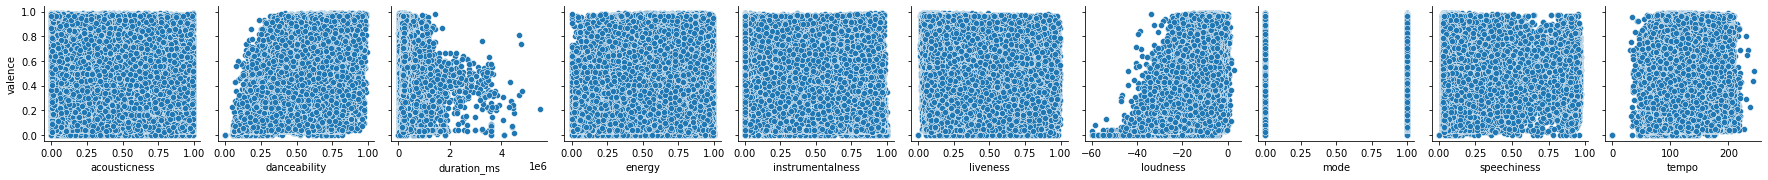

In [14]:
sns.pairplot(data=all_tracks_for_corr,
             y_vars=['valence'],
             x_vars=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo'])

#### Correlation Using Pearson Method

* Firstly, we will use the Pearson correlation coefficient, which is very commonly used.

* It takes values from $-1$ to $+1$. A value of $+1$ shows a total positive linear correlation while a value of $-1$ shows a total negative linear correlation, and finally a value of $0$ shows no linear correlation.

* We will see which numeric features have a correlation closer to the absolute value of 1, and these are the features that we want to include in our models.

* It's also important to state that Pearson's correlation coefficient is sensitive to outliers and that it measures a linear relationship between data.

* In the heatmap in the last we can see valence.

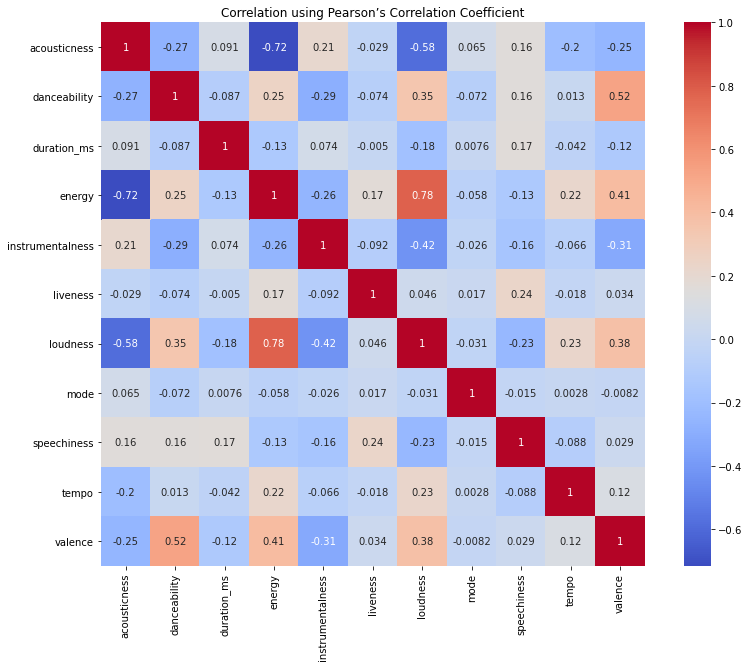

In [15]:
corr = all_tracks_for_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr, square=True, annot=True, cmap='coolwarm', fmt='.2g')
plt.title('Correlation using Pearson’s Correlation Coefficient')
plt.show()

* It is clear that valence has the biggest correlation with danceability and then with energy and loudness. Valence also has a correlation with instrumentalness and acousticness.
* So, we can see that the features with over 0.2 correlation to Valence are danceability, energy, loudness, instrumentalness and accousticness.
* There seems to be very little to no correlation between valence and liveness which I find surprising.
* Also, the correlation between valence and tempo is relatively small, which is an interesting finding.

In [16]:
series = np.abs(corr['valence']).sort_values(ascending=False)
series.round(2)

valence             1.00
danceability        0.52
energy              0.41
loudness            0.38
instrumentalness    0.31
acousticness        0.25
duration_ms         0.12
tempo               0.12
liveness            0.03
speechiness         0.03
mode                0.01
Name: valence, dtype: float64

#### Correlation Using Spearman Method

* As we saw, Pearson's correlation coefficient measures linear relationships, so just to be sure we will also use a different correlation coefficient, Spearman's rank correlation coefficient, which is less sensitive to outliers and best for monotonic relationships between data.

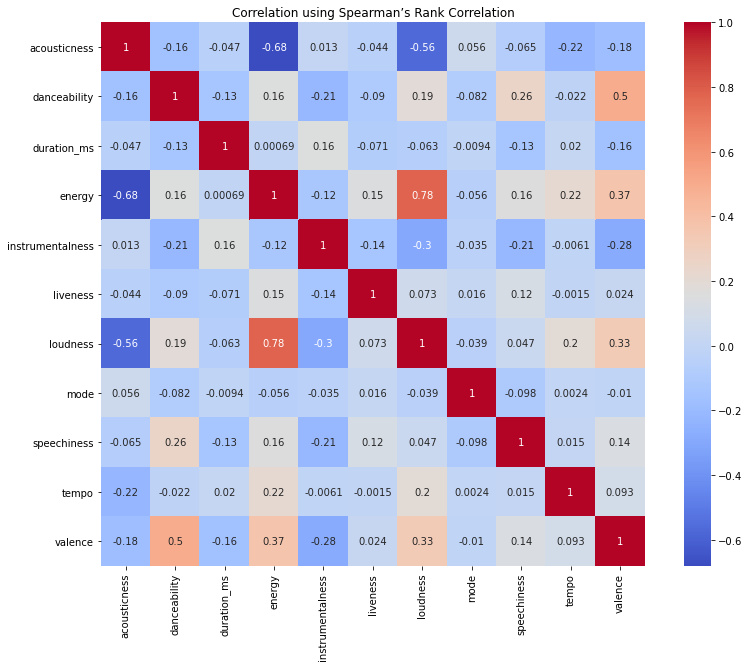

In [17]:
corr2 = all_tracks_for_corr.corr(method='spearman')
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr2, square=True, annot=True, cmap='coolwarm', fmt='.2g')
plt.title('Correlation using Spearman’s Rank Correlation')
plt.show()

We can see that the correlations are very close using Pearson’s Correlation Coefficient and Spearman’s Rank Correlation, with the values using Sprearman's being a bit smaller.

In [18]:
series = np.abs(corr2['valence']).sort_values(ascending=False)
series.round(2)

valence             1.00
danceability        0.50
energy              0.37
loudness            0.33
instrumentalness    0.28
acousticness        0.18
duration_ms         0.16
speechiness         0.14
tempo               0.09
liveness            0.02
mode                0.01
Name: valence, dtype: float64

#### Handling categorical features

Now we will examine the correlation of valence with the categorical features of the dataset, that are key and time_signature.

In [19]:
all_features_tracks = all_tracks[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness',
                                  'loudness', 'mode', 'speechiness', 'tempo', 'key', 'time_signature', 'valence']].copy()

We check the unique values of feature key.

In [20]:
all_features_tracks.key.unique()

array([10.,  6.,  4.,  3.,  7., 11.,  5.,  0.,  1.,  9.,  8.,  2.])

We check the unique values of feature time signature.

In [21]:
all_features_tracks.time_signature.unique()

array([4., 3., 5., 1., 0.])

We make them both type int.

In [22]:
all_features_tracks.key = all_features_tracks.key.astype(int)
all_features_tracks.time_signature = all_features_tracks.time_signature.astype(int)

* We have to transform these two variables to sets of binary dummy variables.
* We do that with `get_dummies()`.

In [23]:
all_features_tracks = pd.get_dummies(all_features_tracks, columns = ['key', 'time_signature'], drop_first=True)

In [24]:
all_features_tracks.loc[:, all_features_tracks.columns.str.contains('key')]

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101934,0,0,0,0,0,0,0,0,0,0,1
101935,0,0,0,0,0,0,1,0,0,0,0
101936,0,0,0,0,0,1,0,0,0,0,0
101937,0,0,0,0,0,0,0,0,1,0,0


In [25]:
all_features_tracks.loc[:, all_features_tracks.columns.str.contains('time_signature')]

,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
101934,0,0,1,0
101935,0,0,1,0
101936,0,0,1,0
101937,0,0,1,0


Now we will examine the correlation of valence with the values of these two features.

In [26]:
dummies_columns = ['time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_3',
                   'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'valence']

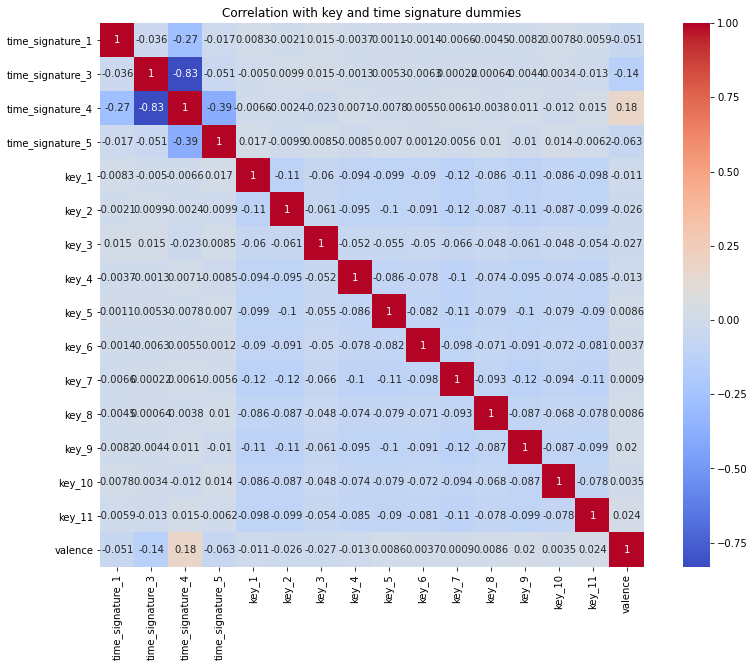

In [27]:
dum_df = pd.DataFrame(data=all_features_tracks, columns=dummies_columns, index=all_features_tracks.index)
corr3 = dum_df.corr(method='spearman')
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr3, square=True, annot=True, cmap='coolwarm', fmt='.2g')
plt.title('Correlation with key and time signature dummies')
plt.show()

* We can see using dummies that all the keys have no/very little corellation with valence.
* The values 4 and 3 of time signature appear to have a correlation over 0.1 with valence.

In [28]:
series2 = np.abs(corr3['valence']).sort_values(ascending=False)
series2.round(2)

valence             1.00
time_signature_4    0.18
time_signature_3    0.14
time_signature_5    0.06
time_signature_1    0.05
key_3               0.03
key_2               0.03
key_11              0.02
key_9               0.02
key_4               0.01
key_1               0.01
key_5               0.01
key_8               0.01
key_6               0.00
key_10              0.00
key_7               0.00
Name: valence, dtype: float64

### Regression

To find the best model that explaines valence we are going to use Linear Regression.

#### Preparation

In [29]:
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import StandardScaler

* We can see that there is difference in the standard deviation among the features and thus we need to standarize them.

In [30]:
all_features_tracks.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
count,101939.000000,101939.000000,1.019390e+05,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,...,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000,101939.000000
mean,0.352124,0.586015,2.467708e+05,0.586479,0.148776,0.197640,-9.462720,0.618154,0.128841,118.358527,...,0.069630,0.113744,0.063734,0.100197,0.063979,0.081343,0.011527,0.098392,0.863458,0.023024
std,0.334855,0.177724,1.904303e+05,0.260170,0.304024,0.175391,6.198508,0.485841,0.203324,30.224074,...,0.254523,0.317502,0.244280,0.300264,0.244718,0.273362,0.106742,0.297846,0.343365,0.149979
min,0.000000,0.000000,1.155000e+03,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040700,0.480000,1.840000e+05,0.411000,0.000000,0.095600,-11.149000,0.000000,0.036400,95.973000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.238000,0.610000,2.168930e+05,0.629000,0.000037,0.124000,-7.599000,1.000000,0.050600,118.067000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.645000,0.714000,2.610550e+05,0.798000,0.034400,0.241000,-5.509000,1.000000,0.104000,136.045000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.996000,0.989000,5.505831e+06,1.000000,1.000000,0.999000,2.719000,1.000000,0.969000,244.035000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* Standardization is of great importance in this situation. When scaling the features so that the predictors have a mean of 0, it makes it easier to interpret the association between the variables. We are going to standarize all the features that we want to see if they can help explain valence in the following models of the assignment.

In [31]:
all_tracks_for_stand = all_features_tracks.copy()
all_tracks_for_stand.drop(['valence'], axis=1, inplace=True)
all_tracks_for_stand.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.294,0.698,235584.0,0.606,0.000003,0.151,-7.447,0.0,0.0262,115.018,...,0,0,0,0,1,0,0,0,1,0
1,0.863,0.719,656960.0,0.308,0.000000,0.253,-10.340,1.0,0.9220,115.075,...,1,0,0,0,0,0,0,1,0,0
2,0.750,0.466,492840.0,0.931,0.000000,0.938,-13.605,0.0,0.9440,79.565,...,0,0,0,0,0,0,0,0,1,0
3,0.763,0.719,316578.0,0.126,0.000000,0.113,-20.254,0.0,0.9380,112.822,...,0,0,0,0,0,0,0,1,0,0
4,0.770,0.460,558880.0,0.942,0.000000,0.917,-13.749,1.0,0.9430,81.260,...,0,1,0,0,0,0,0,0,1,0


In [32]:
standarized_tracks = pd.DataFrame(StandardScaler().fit_transform(all_tracks_for_stand))
standarized_tracks.columns = all_tracks_for_stand.columns
standarized_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,-0.173579,0.630108,-0.058745,0.075031,-0.489350,-0.265923,0.325196,-1.272343,-0.504821,-0.110526,...,-0.273571,-0.35825,-0.260908,-0.333698,3.824921,-0.297566,-0.107986,-0.330348,0.397661,-0.153513
1,1.525671,0.748269,2.154023,-1.070377,-0.489359,0.315638,-0.141532,0.785952,3.900983,-0.108640,...,3.655359,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,3.027112,-2.514703,-0.153513
2,1.188210,-0.675291,1.292181,1.324219,-0.489359,4.221220,-0.668274,-1.272343,4.009186,-1.283537,...,-0.273571,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513
3,1.227033,0.748269,0.366578,-1.769922,-0.489359,-0.482583,-1.740957,-1.272343,3.979676,-0.183184,...,-0.273571,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,3.027112,-2.514703,-0.153513
4,1.247938,-0.709051,1.638976,1.366499,-0.489359,4.101486,-0.691505,0.785952,4.004267,-1.227456,...,-0.273571,2.79135,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101934,-1.034731,0.089943,-0.356446,1.220440,-0.489359,-0.627974,0.788052,0.785952,-0.472852,0.391328,...,-0.273571,-0.35825,-0.260908,-0.333698,-0.261443,3.360604,-0.107986,-0.330348,0.397661,-0.153513
101935,-1.050362,-2.301414,-0.176642,0.909104,-0.471696,0.252920,0.629464,0.785952,-0.336615,2.180441,...,-0.273571,2.79135,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513
101936,-1.038106,-0.264540,-0.108512,1.139723,-0.489354,-0.781346,0.459584,-1.272343,-0.312515,-0.010440,...,3.655359,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513
101937,-0.057110,0.731389,-0.118878,0.620830,-0.489337,-0.614290,0.489914,0.785952,0.108982,-0.276057,...,-0.273571,-0.35825,-0.260908,2.996718,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513


We put valence again with the features together

In [33]:
standarized_tracks['valence'] = all_tracks[['valence']].copy()

In [34]:
standarized_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,valence
0,-0.173579,0.630108,-0.058745,0.075031,-0.489350,-0.265923,0.325196,-1.272343,-0.504821,-0.110526,...,-0.35825,-0.260908,-0.333698,3.824921,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.6220
1,1.525671,0.748269,2.154023,-1.070377,-0.489359,0.315638,-0.141532,0.785952,3.900983,-0.108640,...,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,3.027112,-2.514703,-0.153513,0.5890
2,1.188210,-0.675291,1.292181,1.324219,-0.489359,4.221220,-0.668274,-1.272343,4.009186,-1.283537,...,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.0850
3,1.227033,0.748269,0.366578,-1.769922,-0.489359,-0.482583,-1.740957,-1.272343,3.979676,-0.183184,...,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,3.027112,-2.514703,-0.153513,0.5330
4,1.247938,-0.709051,1.638976,1.366499,-0.489359,4.101486,-0.691505,0.785952,4.004267,-1.227456,...,2.79135,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.0906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101934,-1.034731,0.089943,-0.356446,1.220440,-0.489359,-0.627974,0.788052,0.785952,-0.472852,0.391328,...,-0.35825,-0.260908,-0.333698,-0.261443,3.360604,-0.107986,-0.330348,0.397661,-0.153513,0.7870
101935,-1.050362,-2.301414,-0.176642,0.909104,-0.471696,0.252920,0.629464,0.785952,-0.336615,2.180441,...,2.79135,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.3630
101936,-1.038106,-0.264540,-0.108512,1.139723,-0.489354,-0.781346,0.459584,-1.272343,-0.312515,-0.010440,...,-0.35825,-0.260908,-0.333698,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.4060
101937,-0.057110,0.731389,-0.118878,0.620830,-0.489337,-0.614290,0.489914,0.785952,0.108982,-0.276057,...,-0.35825,-0.260908,2.996718,-0.261443,-0.297566,-0.107986,-0.330348,0.397661,-0.153513,0.7600


In [35]:
standarized_tracks.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,valence
count,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,...,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,1.019390e+05,101939.000000
mean,-1.144661e-16,-2.937034e-16,1.643627e-17,1.370944e-16,5.274967e-16,4.475351e-16,4.143370e-16,5.864135e-16,-1.142695e-16,1.086557e-16,...,1.196088e-16,2.861439e-16,1.388639e-14,-4.271090e-16,-5.300444e-15,5.077968e-15,1.596977e-15,3.970732e-14,-2.305050e-15,0.482813
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.261690
min,-1.051575e+00,-3.297343e+00,-1.289800e+00,-2.254223e+00,-4.893589e-01,-1.126862e+00,-8.153176e+00,-1.272343e+00,-6.336798e-01,-3.916054e+00,...,-3.582496e-01,-2.609076e-01,-3.336984e-01,-2.614433e-01,-2.975656e-01,-1.079857e-01,-3.303478e-01,-2.514703e+00,-1.535127e-01,0.000000
25%,-9.300290e-01,-5.965171e-01,-3.296278e-01,-6.744811e-01,-4.893589e-01,-5.817909e-01,-2.720475e-01,-1.272343e+00,-4.546541e-01,-7.406558e-01,...,-3.582496e-01,-2.609076e-01,-3.336984e-01,-2.614433e-01,-2.975656e-01,-1.079857e-01,-3.303478e-01,3.976613e-01,-1.535127e-01,0.271000
50%,-3.408163e-01,1.349567e-01,-1.568970e-01,1.634354e-01,-4.892355e-01,-4.198661e-01,3.006738e-01,7.859516e-01,-3.848143e-01,-9.645571e-03,...,-3.582496e-01,-2.609076e-01,-3.336984e-01,-2.614433e-01,-2.975656e-01,-1.079857e-01,-3.303478e-01,3.976613e-01,-1.535127e-01,0.477000
75%,8.746403e-01,7.201358e-01,7.501047e-02,8.130128e-01,-3.762092e-01,2.472187e-01,6.378533e-01,7.859516e-01,-1.221777e-01,5.851812e-01,...,-3.582496e-01,-2.609076e-01,-3.336984e-01,-2.614433e-01,-2.975656e-01,-1.079857e-01,-3.303478e-01,3.976613e-01,-1.535127e-01,0.693000
max,1.922860e+00,2.267484e+00,2.761686e+01,1.589431e+00,2.799876e+00,4.569016e+00,1.965276e+00,7.859516e-01,4.132143e+00,4.158178e+00,...,2.791350e+00,3.832775e+00,2.996718e+00,3.824921e+00,3.360604e+00,9.260486e+00,3.027112e+00,3.976613e-01,6.514119e+00,0.993000


#### Best Model 

* We will select the best subset of the independent variables to find the best model for explaining valence.

* First we pick the best model with two variables by adding one variable, then we find the best model with three variables by adding another variable, and it goes on like this.

* It's important to state that it is not guaranteed it will find the best model overall, but it's a good way to find the best model with a large number of independent variables.

In [36]:
data = standarized_tracks.copy()

* The following function takes the dependent variable, the observations, and the set of columns, fits a model, and returns the fitted model.

In [37]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

* We write `forward_add_variable()` to find the best variable to add at each step.

In [38]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

* Then we write `forward_stepwise_selection()` that just does a loop adding a variable at each iteration.

In [39]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [40]:
best_model, _ = forward_stepwise_selection(data, 'valence')
print('Best overall model:', len(best_model.model.exog_names), best_model.model.exog_names)

Finding the best model for 1 variable
['danceability']
Finding the best model for 2 variables
['danceability', 'energy']
Finding the best model for 3 variables
['danceability', 'energy', 'acousticness']
Finding the best model for 4 variables
['danceability', 'energy', 'acousticness', 'instrumentalness']
Finding the best model for 5 variables
['danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo']
Finding the best model for 6 variables
['danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness']
Finding the best model for 7 variables
['danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness', 'speechiness']
Finding the best model for 8 variables
['danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness', 'speechiness', 'duration_ms']
Finding the best model for 9 variables
['danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness', 'speechiness', 'duration_ms', 'mode']
Finding t

In [41]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     2921.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:19:51   Log-Likelihood:                 17821.
No. Observations:              101939   AIC:                        -3.559e+04
Df Residuals:                  101915   BIC:                        -3.537e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.4828      0.001    758.680      0.000       0.482       0.484
danceability         0.1236      0.001    165.659      0.000       0.122       0.125
energy               0.1222      0.001     99.978      0.000       0.120       0.125
acousticness         0.0469      0.001     50.067      0.000       0.045       0.049
instrumentalness    -0.0411      0.001    -54.691      0.000      -0.043      -0.040
tempo                0.0149      0.001     21.962      0.000       0.014       0.016
loudness            -0.0367      0.001    -30.538      0.000      -0.039      -0.034
speechiness         -0.0156      0.001    -20.556      0.000      -0.017      -0.014
duration_ms         -0.0106      0.001    -16.051      0.000      -0.012      -0.009
mode                 0.0089      0.001     13.452      0.000       0.008       0.010
key_1               -0.0094      0.001    -12.069      0.000      -0.011      -0.008
key_9                0.0030      0.001      3.895      0.000       0.002       0.005
key_5                0.0016      0.001      2.097      0.036       0.000       0.003
time_signature_3    -0.0034      0.003     -1.010      0.312      -0.010       0.003
key_6               -0.0035      0.001     -4.638      0.000      -0.005      -0.002
key_2               -0.0032      0.001     -4.146      0.000      -0.005      -0.002
key_4               -0.0023      0.001     -3.089      0.002      -0.004      -0.001
key_8               -0.0021      0.001     -2.823      0.005      -0.004      -0.001
key_7               -0.0018      0.001     -2.302      0.021      -0.003      -0.000
key_11              -0.0013      0.001     -1.694      0.090      -0.003       0.000
key_10              -0.0007      0.001     -0.963      0.336      -0.002       0.001
time_signature_1    -0.0016      0.001     -1.210      0.226      -0.004       0.001
time_signature_5    -0.0037      0.002     -2.058      0.040      -0.007      -0.000
time_signature_4    -0.0073      0.004     -1.870      0.062      -0.015       0.000
==============================================================================
Omnibus:                      705.399   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.249
Skew:                          -0.021   Prob(JB):                    4.26e-106
Kurtosis:                       2.665   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the features that best describe the valence metric based on the R2 score are:

* danceability
* energy
* acousticness
* instrumentalness
* tempo
* loudness
* speechiness
* duration_ms
* mode
* key_1
* key_9
* key_5
* time_signature_3
* key_6
* key_2
* key_4
* key_8
* key_7
* key_11
* key_10
* time_signature_1
* time_signature_5
* time_signature_4

But if we also look at the p-values, we can see that the features that have a p-value less than 0.05 are:

* danceability
* energy
* acousticness
* instrumentalness
* tempo
* loudness
* speechiness
* duration_ms
* mode
* key_1
* key_9
* key_5
* key_6
* key_2
* key_4
* key_8
* key_7
* time_signature_5

It's interesting to see that from these features the ones that have the biggest coefficient, and therefore influence the valence metric more, are danceability and energy. Then acousticness, instrumentalness and loudness follow. Next we can see accousticness, tempo and duration_ms. Finally mode, key and time_signature features appear to have the smallest coefficients. <br> </br>

We can see that these 8 features with the biggest coefficients in the above model where the ones that in the exploration of the data seemed to have the biggest correlation with the valence metric (using Spearman's rank correlation), ehich is what we expected to see. <br> </br>

## A2: Predict Valence

We will use Machine Learning techniques to predict valence based on all the track features, to see in the best models which features influence valence more, and to be able to compare with our previous findings.

* First, we will use different methods that do not use neural networks. For each one of them we will ensure that the hyperparameters are tuned.

* Secondly, we will use neural network.

### Without Neural Networks

* We will use Regression Models, since we want to predict valence, which is a continuous variable.

* We will evaluate the models based on the Mean Absolute Error (MAE), which in our case refers to the magnitude of difference between the prediction of valence and the true value of valence. We will also see the R2 score of each model.

* We will use be using `GridSearchCV` and `KFold` to tune the hyperparameters.

* We will also compare in most models the scores before and after tuning the hyperparameters.

#### Preparation

We get the features that influence more valence, as we saw before. We will use the standarized data.

In [42]:
tracks_for_q2 = all_features_tracks[['valence', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness', 'speechiness', 'duration_ms', 'mode', 'key_1', 'key_9', 'key_5', 'time_signature_3', 'key_6', 'key_2', 'key_4', 'key_8', 'key_7', 'key_11', 'key_10', 'time_signature_1', 'time_signature_5', 'time_signature_4', 'key_3', 'liveness']].copy()
tracks_for_q2

,valence,danceability,energy,acousticness,instrumentalness,tempo,loudness,speechiness,duration_ms,mode,...,key_4,key_8,key_7,key_11,key_10,time_signature_1,time_signature_5,time_signature_4,key_3,liveness
0,0.6220,0.698,0.606,0.294000,0.000003,115.018,-7.447,0.0262,235584.0,0.0,...,0,0,0,0,1,0,0,1,0,0.1510
1,0.5890,0.719,0.308,0.863000,0.000000,115.075,-10.340,0.9220,656960.0,1.0,...,0,0,0,0,0,0,0,0,0,0.2530
2,0.0850,0.466,0.931,0.750000,0.000000,79.565,-13.605,0.9440,492840.0,0.0,...,1,0,0,0,0,0,0,1,0,0.9380
3,0.5330,0.719,0.126,0.763000,0.000000,112.822,-20.254,0.9380,316578.0,0.0,...,0,0,0,0,0,0,0,0,1,0.1130
4,0.0906,0.460,0.942,0.770000,0.000000,81.260,-13.749,0.9430,558880.0,1.0,...,0,0,1,0,0,0,0,1,0,0.9170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101934,0.7870,0.602,0.904,0.005640,0.000000,130.186,-4.578,0.0327,178893.0,1.0,...,0,0,0,1,0,0,0,1,0,0.0875
101935,0.3630,0.177,0.823,0.000406,0.005370,184.260,-5.561,0.0604,213133.0,1.0,...,0,0,1,0,0,0,0,1,0,0.2420
101936,0.4060,0.539,0.883,0.004510,0.000001,118.043,-6.614,0.0653,226107.0,0.0,...,0,0,0,0,0,0,0,1,0,0.0606
101937,0.7600,0.716,0.748,0.333000,0.000007,110.015,-6.426,0.1510,224133.0,1.0,...,0,0,0,0,0,0,0,1,0,0.0899


We will use a sample of 30% of the dataset in all the models following. (Because of the limited computing resources that are available and to be able to produce results faster.) We use the random_state parameter in order to get the same data when we get the sample. 

In [43]:
tracks_for_models = tracks_for_q2.sample(frac=0.3, random_state=22)
tracks_for_models

,valence,danceability,energy,acousticness,instrumentalness,tempo,loudness,speechiness,duration_ms,mode,...,key_4,key_8,key_7,key_11,key_10,time_signature_1,time_signature_5,time_signature_4,key_3,liveness
50283,0.347,0.657,0.415,0.175000,0.000006,96.030,-9.915,0.0250,186347.0,1.0,...,0,0,0,0,0,0,0,1,0,0.1320
18367,0.407,0.673,0.723,0.066800,0.000000,108.119,-6.852,0.0312,179000.0,0.0,...,0,0,0,0,0,0,0,1,0,0.4690
46850,0.354,0.821,0.735,0.092600,0.000000,92.028,-5.949,0.2230,155294.0,0.0,...,0,0,0,0,0,0,0,1,0,0.1970
36380,0.443,0.733,0.662,0.205000,0.000000,135.960,-5.763,0.2230,208676.0,0.0,...,0,0,0,0,0,0,0,1,0,0.0575
7334,0.477,0.618,0.766,0.039300,0.007630,125.993,-8.620,0.0487,242000.0,1.0,...,0,0,1,0,0,0,0,1,0,0.1800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98757,0.592,0.455,0.565,0.289000,0.000000,78.632,-6.381,0.3360,249000.0,1.0,...,0,0,1,0,0,0,0,1,0,0.1980
59325,0.713,0.444,0.913,0.076500,0.000000,178.028,-4.040,0.0618,264987.0,1.0,...,0,0,0,1,0,0,0,1,0,0.3360
82235,0.840,0.487,0.682,0.779000,0.034900,145.055,-6.329,0.1070,219743.0,1.0,...,0,0,0,0,0,0,0,0,0,0.0793
81906,0.191,0.434,0.884,0.000728,0.004580,180.029,-7.128,0.0930,154960.0,0.0,...,0,0,1,0,0,0,0,1,0,0.1050


* We, then, need to split our dataset to train and test data. 

* We will evaluate our predictions on a holdout 20% testing dataset.

* Trees and Forests don't need standarized data.

In [44]:
from sklearn.model_selection import train_test_split

# Get dataset
X, y = (tracks_for_models.loc[:, tracks_for_models.columns != 'valence'].values, tracks_for_models['valence'].values)

# Split the dataset into a training and a testing set
# Test set will be the 20% taken randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

print(X_train.shape, y_train.shape)

(24465, 25) (24465,)


We standarize the X_train and X_split to have for the models that need the features standarized to be trained. These models are KNNeighbors Regressor and SGD Regressor.

In [45]:
Xst_train = StandardScaler().fit_transform(X_train)
Xst_test = StandardScaler().fit_transform(X_test)

#### Model 1: Decision Tree Regressor

##### Without tuning the hyperparameters.

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

valence_rg = DecisionTreeRegressor(max_depth=2)
valence_rg.fit(X_train, y_train)

predicted = valence_rg.predict(X_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.1844094577479371
R2 score:  0.266427112937059


##### Tunig the hyperparameters using `GridSearchCV`.

In [47]:
parameters = {
  'max_depth': list(range(1, 11))
}

cv = KFold(n_splits=5, shuffle=True, random_state=13)

gs_valence_rg = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

gs_valence_rg = gs_valence_rg.fit(X_train, y_train)

print(gs_valence_rg.best_estimator_)
print(gs_valence_rg.best_params_)

DecisionTreeRegressor(max_depth=7)
{'max_depth': 7}


In [48]:
predicted = gs_valence_rg.predict(X_test)

dt_mae = mean_absolute_error(y_test, predicted)
dt_score = metrics.r2_score(y_test, predicted)

print('Loss: ', dt_mae)
print('R2 score: ', dt_score)

Loss:  0.16291756791473305
R2 score:  0.390263251478591


#### Model 2: AdaBoost Regressor

Using the best max depth for the Decision Tree that we found above using the GridSearchCV

In [101]:
from sklearn.ensemble import AdaBoostRegressor

dsr = DecisionTreeRegressor(max_depth=7)
valence_rg = AdaBoostRegressor(dsr, n_estimators=5000)

valence_rg.fit(X_train, y_train)

predicted = valence_rg.predict(X_test)

ada_mae = mean_absolute_error(y_test, predicted)
ada_score = metrics.r2_score(y_test, predicted)

print('Loss: ', ada_mae)
print('R2 score: ', ada_score)

Loss:  0.19043855167978035
R2 score:  0.2679646206327664


#### Model 3: XGB Regressor

##### Without tuning the hyperparameters.

In [50]:
import xgboost as xgb

valence_rg = xgb.XGBRegressor()

valence_rg.fit(X_train, y_train)

predicted = valence_rg.predict(X_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.1475669323733345
R2 score:  0.48503943962989793


##### Tunig the hyperparameters using `GridSearchCV`.

In [51]:
parameters = {
    'max_depth': list(range(2, 13, 2)),
    'subsample': [0.7, 0.8, 0.9]
}

xgb_rg = GridSearchCV(xgb.XGBRegressor(), parameters, cv=cv)

xgb_rg = xgb_rg.fit(X_train, y_train)

print(xgb_rg.best_estimator_)
print(xgb_rg.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)
{'max_depth': 4, 'subsample': 0.9}


In [52]:
predicted = xgb_rg.predict(X_test)

xgb_mae = mean_absolute_error(y_test, predicted)
xgb_score = metrics.r2_score(y_test, predicted)

print('Loss: ', xgb_mae)
print('R2 score: ', xgb_score)

Loss:  0.1471599202073912
R2 score:  0.49322187011138885


#### Model 4: LGBM Regressor

##### Without tuning the hyperparameters.

In [53]:
import lightgbm as lgb

valence_rg = lgb.LGBMRegressor()

valence_rg.fit(X_train, y_train)

predicted = valence_rg.predict(X_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.14693177027542192
R2 score:  0.49728871621339266


##### Tunig the hyperparameters using `GridSearchCV`.

In [54]:
parameters = {
    'num_leaves': list(range(5, 20, 5)),
    'n_estimators': [400, 700],
    'max_depth': list(range(5, 20, 5))
}

lgb_rg = GridSearchCV(lgb.LGBMRegressor(), parameters, cv=cv)

lgb_rg = lgb_rg.fit(X_train, y_train)

print(lgb_rg.best_estimator_)
print(lgb_rg.best_params_)

LGBMRegressor(max_depth=10, n_estimators=700, num_leaves=10)
{'max_depth': 10, 'n_estimators': 700, 'num_leaves': 10}


In [55]:
predicted = lgb_rg.predict(X_test)

lgb_mae = mean_absolute_error(y_test, predicted)
lgb_score = metrics.r2_score(y_test, predicted)

print('Loss: ', lgb_mae)
print('R2 score: ', lgb_score)

Loss:  0.14546269160586478
R2 score:  0.503659033144946


#### Model 5: Voting Regressor

* Another approach to predict valence is to ensemble models and then combine their outputs.

* By using `VotingRegressor` we combine LightGBM and XGBoost and use the average of their predicted values.

In [56]:
from sklearn.ensemble import VotingRegressor

valence_rg = VotingRegressor(estimators=[('xgb', xgb_rg), 
                                        ('lgb', lgb_rg)],
                            n_jobs=-1)
                       
valence_rg.fit(X_train, y_train)

VotingRegressor(estimators=[('xgb',
                             GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
                                          estimator=XGBRegressor(base_score=None,
                                                                 booster=None,
                                                                 colsample_bylevel=None,
                                                                 colsample_bynode=None,
                                                                 colsample_bytree=None,
                                                                 enable_categorical=False,
                                                                 gamma=None,
                                                                 gpu_id=None,
                                                                 importance_type=None,
                                                                 interaction_constraints=None,
               

In [57]:
predicted = valence_rg.predict(X_test)

v_mae = mean_absolute_error(y_test, predicted)
v_score = metrics.r2_score(y_test, predicted)

print('Loss: ', v_mae)
print('R2 score: ', v_score)

Loss:  0.145398019547462
R2 score:  0.5051156604802417


#### Model 6: Stacking Regressor

* We will now test `StackingRegressor`, were we will use the predictions of individual models as inputs to a final estimator. Basically we are creating a stack where the top of the stack is the final estimator, and below we place the other models.

* Again we will use the output of LightGBM and XGBoost.

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

estimators = [('xgb', xgb_rg), ('lgb', lgb_rg)]
final_estimator = LinearRegression()

stacking_rg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1, cv=5)

stacking_rg.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
                                            estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   enable_categorical=False,
                                                                   gamma=None,
                                                                   gpu_id=None,
                                                                   importance_type=None,
                                                                

In [59]:
predicted = stacking_rg.predict(X_test)

s_mae = mean_absolute_error(y_test, predicted)
s_score = metrics.r2_score(y_test, predicted)

print('Loss: ', s_mae)
print('R2 score: ', s_score)

Loss:  0.14520163352006715
R2 score:  0.5060768826505251


#### Model 7: Random Forest Regressor

##### Without tuning the hyperparameters.

In [60]:
from sklearn.ensemble import RandomForestRegressor

valence_rg = RandomForestRegressor()

valence_rg.fit(X_train, y_train)

predicted = valence_rg.predict(X_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.147986139807095
R2 score:  0.4872022339027424


##### Tunig the hyperparameters using `GridSearchCV`.

In [61]:
parameters = [
  {'n_estimators': (300, 500, 1000)}
 ]

gs_valence_rg = GridSearchCV(RandomForestRegressor(), parameters, cv=cv)

gs_valence_rg = gs_valence_rg.fit(X_train, y_train)

print(gs_valence_rg.best_estimator_)
print(gs_valence_rg.best_params_)

RandomForestRegressor(n_estimators=1000)
{'n_estimators': 1000}


In [62]:
predicted = gs_valence_rg.predict(X_test)

rf_mae = mean_absolute_error(y_test, predicted)
rf_score = metrics.r2_score(y_test, predicted)

print('Loss: ', rf_mae)
print('R2 score: ', rf_score)

Loss:  0.1474408961288213
R2 score:  0.4906531784044281


#### Model 8: Bagging Regressor

In [63]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor 

valence_rg = BaggingRegressor(n_estimators=20)

valence_rg.fit(X_train, y_train)

predicted = gs_valence_rg.predict(X_test)

bag_mae = mean_absolute_error(y_test, predicted)
bag_score = metrics.r2_score(y_test, predicted)

print('Loss: ', bag_mae)
print('R2 score: ', bag_score)

Loss:  0.1474408961288213
R2 score:  0.4906531784044281


#### Model 9: KNeighbors Regressor

##### Without tuning the hyperparameters

In [64]:
from sklearn.neighbors import KNeighborsRegressor

valence_rg = KNeighborsRegressor()

valence_rg.fit(Xst_train, y_train)

predicted = valence_rg.predict(Xst_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.17072446918424064
R2 score:  0.3240569326736257


##### Tunig the hyperparameters using `GridSearchCV`.

In [65]:
parameters = {
  'n_neighbors':list(range(40, 101, 5)),
  'p':list(range(1,2))
}

gs_valence_rg = GridSearchCV(KNeighborsRegressor(), parameters, cv=cv)

gs_valence_rg = gs_valence_rg.fit(Xst_train, y_train)

print(gs_valence_rg.best_estimator_)
print(gs_valence_rg.best_params_)

KNeighborsRegressor(n_neighbors=40, p=1)
{'n_neighbors': 40, 'p': 1}


In [66]:
predicted = gs_valence_rg.predict(Xst_test)

kn_mae = mean_absolute_error(y_test, predicted)
kn_score = metrics.r2_score(y_test, predicted)

print('Loss: ', kn_mae)
print('R2 score: ', kn_score)

Loss:  0.1702086448422429
R2 score:  0.3697598350473149


#### Model 10: SGD Regressor

##### Without tuning the hyperparameters.

In [67]:
from sklearn.linear_model import SGDRegressor

valence_rg = SGDRegressor()

valence_rg.fit(Xst_train, y_train)

predicted = valence_rg.predict(Xst_test)

print('Loss: ', mean_absolute_error(y_test, predicted))
print('R2 score: ', metrics.r2_score(y_test, predicted))

Loss:  0.16537653992870174
R2 score:  0.39064037829947484


##### Tunig the hyperparameters using `GridSearchCV`.

In [68]:
parameters = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

gs_valence_rg = GridSearchCV(SGDRegressor(), parameters, cv=cv)

gs_valence_rg = gs_valence_rg.fit(Xst_train, y_train)

print(gs_valence_rg.best_estimator_)
print(gs_valence_rg.best_params_)

SGDRegressor(alpha=0.001, loss='huber', penalty='elasticnet')
{'alpha': 0.001, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'elasticnet'}


In [69]:
predicted = gs_valence_rg.predict(Xst_test)

sgd_mae = mean_absolute_error(y_test, predicted)
sgd_score = metrics.r2_score(y_test, predicted)

print('Loss: ', sgd_mae)
print('R2 score: ', sgd_score)

Loss:  0.1644891739109157
R2 score:  0.39051395040144643


#### Conclusion

To make it easier to spot the best model we will print all the info together.

In [102]:
model_conclusion = pd.DataFrame({'Model': ['Decision Tree Regressor', 
                                            'Ada Boost Regressor ', 
                                            'XGB Regressor',
                                            'LGBM Regressor',
                                            'Voting Regressor',
                                            'Stacking Regressor',
                                            'Random Forest Regressor',
                                            'KNeighbors Regressor',
                                            'Stochastic Gradient Descent Regressor',
                                            'Bagging Regressor'],
                                        'Mean Absolute Error': [dt_mae,
                                                                ada_mae,
                                                                xgb_mae,
                                                                lgb_mae,
                                                                v_mae,
                                                                s_mae,
                                                                rf_mae,
                                                                kn_mae,
                                                                sgd_mae,
                                                                bag_mae],
                                            'R2 score': [dt_score,
                                                         ada_score,
                                                         xgb_score,
                                                         lgb_score,
                                                         v_score,
                                                         s_score,
                                                         rf_score,
                                                         kn_score,
                                                         sgd_score,
                                                         bag_score]})

As we can see the Stacking Regressor has the best Mean Absolute Error.

In [103]:
model_conclusion.sort_values(by="Mean Absolute Error", ascending=True)

,Model,Mean Absolute Error,R2 score
5,Stacking Regressor,0.145202,0.506077
4,Voting Regressor,0.145398,0.505116
3,LGBM Regressor,0.145463,0.503659
2,XGB Regressor,0.147160,0.493222
6,Random Forest Regressor,0.147441,0.490653
9,Bagging Regressor,0.147441,0.490653
0,Decision Tree Regressor,0.162918,0.390263
8,Stochastic Gradient Descent Regressor,0.164489,0.390514
7,KNeighbors Regressor,0.170209,0.369760
1,Ada Boost Regressor,0.190439,0.267965


We are now going to see which features influence valence more.

In [72]:
feature_cols = [ col for col in tracks_for_models.columns if col != 'valence']

* First we will see the feature importances in the LGBM Regressor Model. We fit the model with all the data. The features that appear to be influencing the valence metric more are danceability, energy, speechiness, tempo, loudness,instrumentalness, acousticness, duration_ms and liveness. Mode, key and time_signature values do not seem to influence the valence metric much.

In [73]:
lgb_reg = lgb.LGBMRegressor(max_depth=5, n_estimators=700, num_leaves=10)
lgb_reg.fit(tracks_for_models.loc[:, tracks_for_models.columns != 'valence'].values, tracks_for_models['valence'].values)

LGBMRegressor(max_depth=5, n_estimators=700, num_leaves=10)

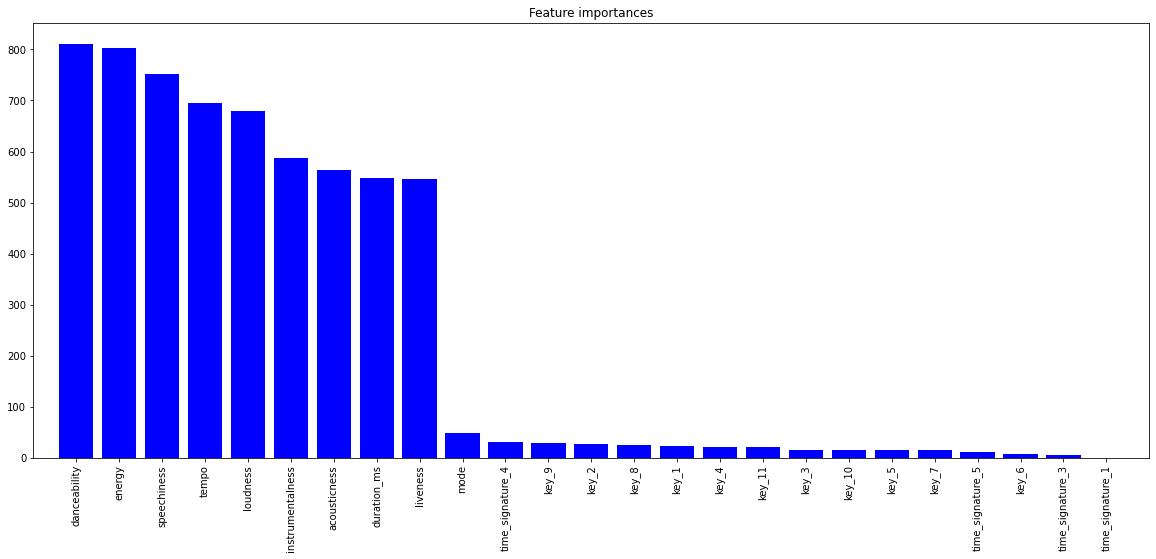

In [74]:
importances_lgb = lgb_reg.feature_importances_

indices_lgb = np.argsort(importances_lgb)[::-1]

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_lgb[indices_lgb],
        tick_label=[feature_cols[x] for x in indices_lgb],
        color="b", align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=90)

* Now we will see the feature importances in the Random Forest Regressor Model. We fit the model with all the data. The features that appear to be influencing the valence metric more are again danceability, energy, duration_ms, acousticness, tempo, speechiness, loudness, instrumentalness adn liveness, with danceability being by far the most influential. Mode, key and time_signature values do not seem to influence the valence metric much here too.

* The main difference from the importances from the two models is that using the Random Forest Regressor there is a bigger difference in the importances between danceablitiy, energy and the rest of the 9 more important, while using the LGBM Regressor the importances of the 9 more important features appear to be closer.

In [75]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(tracks_for_models.loc[:, tracks_for_models.columns != 'valence'].values, tracks_for_models['valence'].values)

RandomForestRegressor(n_estimators=1000)

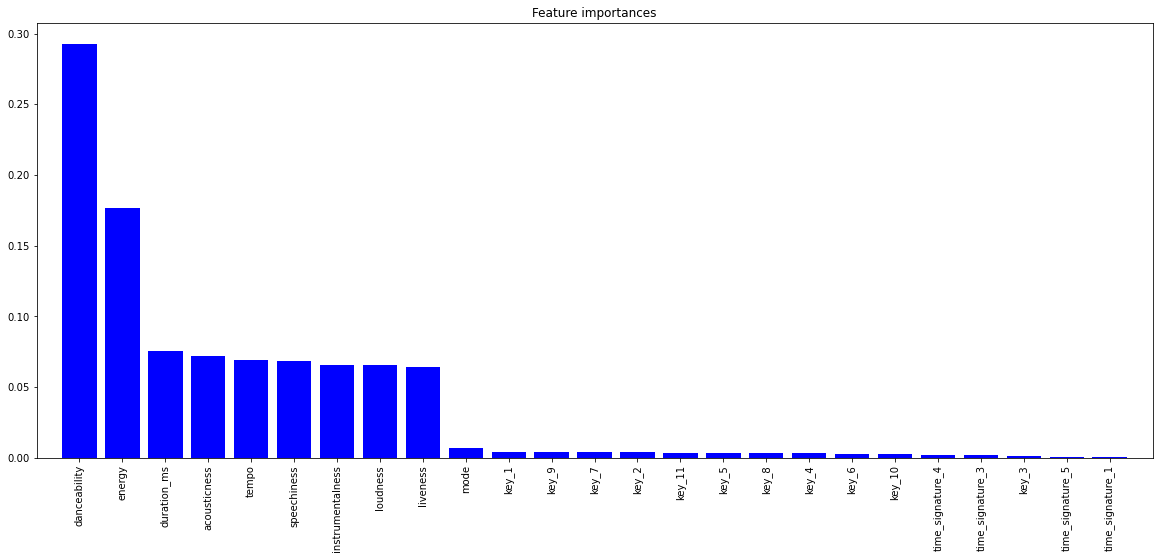

In [76]:
importances = rf_reg.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        tick_label=[feature_cols[x] for x in indices],
        color="b", align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=90)

What we can surely see is that the 8 more important featuers in both models are the features that had the biggest coefficients in the models in the previous question of the Assignment, with the Linear Regressions.

### With Neural Network

It is now time to try out the neural networks.

#### Preparation

In [77]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

* We need to normalize the data that are going to be used to train the model.

* We use `Normalization()` and call `adapt()`.

* Adaptation will produce a normalizer that holds the mean, the variance, and the count.

In [78]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

tf.Tensor(
[[ 5.85e-01  5.87e-01  3.53e-01  1.48e-01  1.18e+02 -9.49e+00  1.30e-01
   2.47e+05  6.23e-01  9.92e-02  9.93e-02  8.26e-02  9.93e-02  6.99e-02
   1.01e-01  7.57e-02  6.42e-02  1.15e-01  7.95e-02  6.27e-02  1.24e-02
   2.36e-02  8.61e-01  3.23e-02  1.99e-01]], shape=(1, 25), dtype=float32)
tf.Tensor(
[[3.15e-02 6.75e-02 1.13e-01 9.25e-02 9.12e+02 3.84e+01 4.15e-02 3.94e+10
  2.35e-01 8.94e-02 8.95e-02 7.58e-02 8.95e-02 6.50e-02 9.08e-02 7.00e-02
  6.01e-02 1.02e-01 7.32e-02 5.88e-02 1.23e-02 2.30e-02 1.20e-01 3.13e-02
  3.12e-02]], shape=(1, 25), dtype=float32)
<tf.Variable 'count:0' shape=() dtype=int64, numpy=24465>


#### Neural Network

After exploring our options and after some trials with different models we concluded to the following:

Number of features (columns) that we put in the models.

In [79]:
FEATURES = 25

* To counter overfitting we will add *regularization*, which pushes the weights towards zero. 

* By using `l2(0.001)` every coefficient $w$ in the weight matrix will add $0.001 \times w^2$ to the total loss.

* We calculate the Mean Absolute Error as a measure of performance.

* We use the Adam optimizer.

In [80]:
def build_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(32, activation='elu',
                    kernel_regularizer=regularizers.l2(0.001),
                    input_shape=(FEATURES,)),
        layers.Dense(32, activation='elu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

model = build_compile_model()

* Below we can see a summary of the model.

* There are 51 non-trainable parameters in the normalization layer.

* For the 25 features that we use in the model we have a mean and a standard deviation per feature plus a total count, $2 \times 25 + 1 = 51$.

In [81]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 25)               51        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,972
Trainable params: 1,921
Non-trainable params: 51
_________________________________________________________________


* We'll train for 100 epochs.

* At each epoch we will perform a validation, keeping 20% of the epoch data for the validation, in order to test even more the model we built.

* We do not want to overfit the training so we define an early stop if the validation loss does not change in 20 epochs. For that we will use `EarlyStopping`.

In [82]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

num_epochs = 100

history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs, 
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop])

Epoch 1/100
612/612 [==============================] - 3s 3ms/step - loss: 0.2479 - val_loss: 0.2191
Epoch 2/100
612/612 [==============================] - 2s 3ms/step - loss: 0.2082 - val_loss: 0.2041
Epoch 3/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1972 - val_loss: 0.1926
Epoch 4/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1891 - val_loss: 0.1864
Epoch 5/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1832 - val_loss: 0.1852
Epoch 6/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1784 - val_loss: 0.1796
Epoch 7/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1754 - val_loss: 0.1746
Epoch 8/100
612/612 [==============================] - 2s 3ms/step - loss: 0.1724 - val_loss: 0.1734
Epoch 9/100
612/612 [==============================] - 1s 2ms/step - loss: 0.1703 - val_loss: 0.1699
Epoch 10/100
612/612 [==============================] - 2s 2ms/step - loss: 0.1687 - val_lo

* We will plot the evolution of the training error and the validation error.

In [83]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

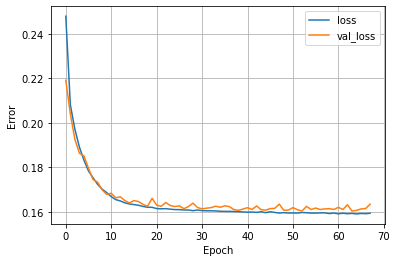

In [84]:
plot_loss(history)

* We will evaluate performance of the model by getting the Mean Absolute Error.

In [85]:
model.evaluate(X_train, y_train, verbose=0)

0.16153867542743683

### Conclusion

Comparing the results we obtained by using a neural network with the results we obtained by using the best non-connectivist approach, we can clearly see that the non-connectivist approach of Stacking Regressor (by using the output of LightGBM and XGBoost) is the best choice, since with it we achieved the best results.

### Final Test

We are going to test our best models with different data to better evaluate them.

#### Preparation

In [86]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotify_config import config

DON'T FORGET <br> </br>

*Before running the notebook you should have the following file *spotify_ids.txt in the same folder with this notebook*

This txt file has circa 1000 unique song ids that will be used for the evaluation.

* We will get for each of the given tracks, its [audio features](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-several-audio-features), retrieved from Spotify API.

In [87]:
final_test_data = pd.read_csv('spotify_ids.txt', header=None)
final_test_data

,0
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx
...,...
1157,4lUmnwRybYH7mMzf16xB0y
1158,1fzf9Aad4y1RWrmwosAK5y
1159,3E3pb3qH11iny6TFDJvsg5
1160,3yTkoTuiKRGL2VAlQd7xsC


In [88]:
final_test_data.columns = ['song_id']
final_test_data

,song_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b
3,4MzXwWMhyBbmu6hOcLVD49
4,5Kskr9LcNYa0tpt5f0ZEJx
...,...
1157,4lUmnwRybYH7mMzf16xB0y
1158,1fzf9Aad4y1RWrmwosAK5y
1159,3E3pb3qH11iny6TFDJvsg5
1160,3yTkoTuiKRGL2VAlQd7xsC


* For storing our credentials, we create a file `spotify_config.py` with the following contents:

  ```
  config = {
      'client_id' : 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
      'client_secret' :'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
  }
  ```

In [89]:
client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [90]:
features = {}
all_track_ids = list(final_test_data['song_id'].unique())

* We iterate to get the features.

In [91]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


In [92]:
final_test_tracks = pd.DataFrame.from_dict(features, orient='index')
final_test_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,audio_features,4MzXwWMhyBbmu6hOcLVD49,spotify:track:4MzXwWMhyBbmu6hOcLVD49,https://api.spotify.com/v1/tracks/4MzXwWMhyBbm...,https://api.spotify.com/v1/audio-analysis/4MzX...,205090,4
5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,audio_features,5Kskr9LcNYa0tpt5f0ZEJx,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,https://api.spotify.com/v1/audio-analysis/5Ksk...,205458,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4lUmnwRybYH7mMzf16xB0y,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,audio_features,4lUmnwRybYH7mMzf16xB0y,spotify:track:4lUmnwRybYH7mMzf16xB0y,https://api.spotify.com/v1/tracks/4lUmnwRybYH7...,https://api.spotify.com/v1/audio-analysis/4lUm...,257428,4
1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,audio_features,1fzf9Aad4y1RWrmwosAK5y,spotify:track:1fzf9Aad4y1RWrmwosAK5y,https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...,https://api.spotify.com/v1/audio-analysis/1fzf...,187310,4
3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,audio_features,3E3pb3qH11iny6TFDJvsg5,spotify:track:3E3pb3qH11iny6TFDJvsg5,https://api.spotify.com/v1/tracks/3E3pb3qH11in...,https://api.spotify.com/v1/audio-analysis/3E3p...,209299,4
3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,audio_features,3yTkoTuiKRGL2VAlQd7xsC,spotify:track:3yTkoTuiKRGL2VAlQd7xsC,https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...,https://api.spotify.com/v1/audio-analysis/3yTk...,202204,4


In [93]:
final_test_tracks = final_test_tracks.reset_index(drop=True).rename(columns={'id' : 'song_id'})
final_test_tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
1,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
2,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
3,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,audio_features,4MzXwWMhyBbmu6hOcLVD49,spotify:track:4MzXwWMhyBbmu6hOcLVD49,https://api.spotify.com/v1/tracks/4MzXwWMhyBbm...,https://api.spotify.com/v1/audio-analysis/4MzX...,205090,4
4,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,audio_features,5Kskr9LcNYa0tpt5f0ZEJx,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,https://api.spotify.com/v1/audio-analysis/5Ksk...,205458,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,audio_features,4lUmnwRybYH7mMzf16xB0y,spotify:track:4lUmnwRybYH7mMzf16xB0y,https://api.spotify.com/v1/tracks/4lUmnwRybYH7...,https://api.spotify.com/v1/audio-analysis/4lUm...,257428,4
1158,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,audio_features,1fzf9Aad4y1RWrmwosAK5y,spotify:track:1fzf9Aad4y1RWrmwosAK5y,https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...,https://api.spotify.com/v1/audio-analysis/1fzf...,187310,4
1159,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,audio_features,3E3pb3qH11iny6TFDJvsg5,spotify:track:3E3pb3qH11iny6TFDJvsg5,https://api.spotify.com/v1/tracks/3E3pb3qH11in...,https://api.spotify.com/v1/audio-analysis/3E3p...,209299,4
1160,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,audio_features,3yTkoTuiKRGL2VAlQd7xsC,spotify:track:3yTkoTuiKRGL2VAlQd7xsC,https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...,https://api.spotify.com/v1/audio-analysis/3yTk...,202204,4


In [94]:
final_test_tracks.key.unique()

array([10,  0,  1,  4, 11,  8,  7,  6,  3,  5,  2,  9])

In [95]:
final_test_tracks.time_signature.unique()

array([4, 3, 5, 1])

* We want to be sure that the testing final tracks have the same features as the trained data in the models.

* We get dummies for the two categorical data that we used in our models before.

In [96]:
final_test_tracks = pd.get_dummies(final_test_tracks, columns = ['key', 'time_signature'])
final_test_tracks.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'song_id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7',
       'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

* We drop the column key_0, since it's ot included in the trained data.

In [97]:
final_test_tracks.drop(['key_0'], axis=1, inplace=True)
final_test_tracks.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'song_id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8',
       'key_9', 'key_10', 'key_11', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

* We keep all the tracks' features that we used in the models we trained.

In [98]:
important_final_test = final_test_tracks[['valence', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'tempo', 'loudness', 'speechiness', 'duration_ms', 'mode', 'key_1', 'key_9', 'key_5', 'time_signature_3', 'key_6', 'key_2', 'key_4', 'key_8', 'key_7', 'key_11', 'key_10', 'time_signature_1', 'time_signature_5', 'time_signature_4', 'key_3', 'liveness']].copy()

We will evaluate the neural network model with the final test data, even though it was not our best model. As we will see in a bit, our best model was by using a non-connectivist approach.

In [99]:
model.evaluate(important_final_test.loc[:, important_final_test.columns != 'valence'].values, important_final_test['valence'].values, verbose=0)

0.15750262141227722

#### Best Model: Stacking Regressor

We will now evaluate the model of the non-connectivist approach with the best Mean Ablsolute Error, which was the model we trained using Stacking Regressor (by using the output of LightGBM and XGBoost). It has the smallest error and has a better performance than the neural network we saw before.

In [100]:
mean_absolute_error(important_final_test['valence'].values, stacking_rg.predict(important_final_test.loc[:, important_final_test.columns != 'valence'].values))

0.14828214163787856

#### Conclusion

Comparing the results we obtained by using a neural network with the results we obtained by using the best non-connectivist approach, we can clearly see that the non-connectivist approach of Stacking Regressor (by using the output of LightGBM and XGBoost) is the best choice, since with it we achieved the best results.